In [1]:
import os 
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

def load_base_model(base_model_name):
    model = AutoModelForCausalLM.from_pretrained(base_model_name, dtype=torch.bfloat16, device_map="auto")
    tokenizer = AutoTokenizer.from_pretrained(base_model_name)

    tokenizer.padding_side = "left"
    tokenizer.pad_token = tokenizer.eos_token
    return model, tokenizer

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
model_name="Qwen/Qwen3-4B-Instruct-2507"
model, tokenizer = load_base_model(model_name)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
def generate_diverse_texts(model, tokenizer, text, special_tag, batch_size, max_new_tokens, temperature):

    # ================================================
    # Generate text with special tags
    special_tag_input  = f"<{special_tag}>"
    special_tag_output = f"</{special_tag}>"
    text = special_tag_input + text + special_tag_output
    messages = [
        {
            "role": "system",
            "content": (
                "Provide similar text.\n\n"
                f"Provide output in {special_tag_input} {special_tag_output} tags"
            )
        },
        {
            "role": "user",
            "content": text
        }
    ]

    input_ids = tokenizer.apply_chat_template(
        messages,
        tokenize=True,
        add_generation_prompt=True,
        return_tensors="pt"
    ).to(model.device)
    input_ids = input_ids.repeat(batch_size, 1)

    outputs = model.generate(
        input_ids,
        max_new_tokens=max_new_tokens,
        temperature=temperature,
        do_sample=True,
    )
    # ================================================
    # Decode text and post-process by fetching text between special tags
    generated_texts = []
    for i in range(len(outputs)):
        output = tokenizer.decode(
            outputs[i][input_ids.shape[-1]:],
            skip_special_tokens=True
        )
        start = text.find(special_tag_input)
        end = text.find(special_tag_output, start)
        generated_texts.append(output[start+len(special_tag_input):end])
    return generated_texts


In [23]:
text = """918, 163, 173"""
special_tag = "TEXT"
batch_size = 32
max_new_tokens = 256
temperature = 0.6

generated_texts = generate_diverse_texts(model, tokenizer, 
                                         text, special_tag, 
                                         batch_size, 
                                         max_new_tokens, 
                                         temperature)
for p in generated_texts:
    print(p)
    
# 345, 678, 901
# 901, 234, 567
# 101, 202, 303
# 987, 654, 321
# 345, 678, 901
# 345, 678, 901
# 345, 678, 901
# 111, 222, 333
# 111, 222, 333
# 321, 654, 987
# 345, 678, 901
# 987, 654, 321
# 321, 654, 987
# 321, 654, 987
# 234, 567, 890
# 345, 678, 901

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


919, 164, 174
915, 164, 172
928, 165, 182
935, 165, 182
913, 165, 177
921, 165, 181
941, 159, 178
912, 165, 182
912, 159, 168
856, 132, 142
920, 165, 175
927, 161, 181
923, 167, 183
912, 165, 182
924, 171, 185
912, 165, 181
945, 182, 192
912, 165, 178
842, 189, 197
921, 165, 175
912, 167, 182
923, 167, 183
842, 137, 149
921, 165, 175
911, 164, 175
912, 165, 178
945, 156, 178
926, 187, 198
935, 178, 191
913, 165, 175
912, 165, 178
929, 172, 189


In [28]:
import torch
import torch.nn as nn

def measure_ppls_batch_per_sample(model, tokenizer, texts):
    """
    Compute per-sample perplexity (PPL) using left padding in batch mode.

    model: HuggingFace CausalLM
    tokenizer: corresponding tokenizer
    texts: list of strings
    """

    model.eval()
    device = model.device

    # GPT-style models often do not have pad_token by default
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    # Use left padding for causal LM
    tokenizer.padding_side = "left"

    # ===============================
    # Tokenize with left padding
    # ===============================
    encodings = tokenizer(
        texts,
        return_tensors="pt",
        padding=True,
        truncation=True
    )

    input_ids = encodings["input_ids"].to(device)
    attention_mask = encodings["attention_mask"].to(device)

    with torch.no_grad():
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        logits = outputs.logits

    # Shift for next-token prediction
    shift_logits = logits[:, :-1, :].contiguous()
    shift_labels = input_ids[:, 1:].contiguous()
    shift_mask = attention_mask[:, 1:].contiguous()

    # Compute token-level cross entropy without reduction
    loss_fct = nn.CrossEntropyLoss(reduction="none")
    token_loss = loss_fct(
        shift_logits.view(-1, shift_logits.size(-1)),
        shift_labels.view(-1)
    )

    token_loss = token_loss.view(shift_labels.size())

    # Mask out padding tokens
    token_loss = token_loss * shift_mask

    # Compute average loss per sentence
    sentence_loss = token_loss.sum(dim=1) / shift_mask.sum(dim=1)

    # Convert to perplexity
    ppls = torch.exp(sentence_loss)

    return ppls.tolist()

text = "918, 163, 173"
generated_texts = ['919, 164, 174',
                '915, 164, 172',
                '928, 165, 182',
                '935, 165, 182',
                '913, 165, 177',
                '921, 165, 181',
                '941, 159, 178',
                '912, 165, 182',
                '912, 159, 168',
                '856, 132, 142',
                '920, 165, 175',
                '927, 161, 181',
                '923, 167, 183',
                '912, 165, 182',
                '924, 171, 185',
                '912, 165, 181',
                '945, 182, 192',
                '912, 165, 178',
                '842, 189, 197',
                '921, 165, 175',
                '912, 167, 182',
                '923, 167, 183',
                '842, 137, 149',
                '921, 165, 175',
                '911, 164, 175',
                '912, 165, 178',
                '945, 156, 178',
                '926, 187, 198',
                '935, 178, 191',
                '913, 165, 175',
                '912, 165, 178',
                '929, 172, 189']
target_texts = [text] + generated_texts
ppls = measure_ppls_batch_per_sample(model, tokenizer, target_texts)


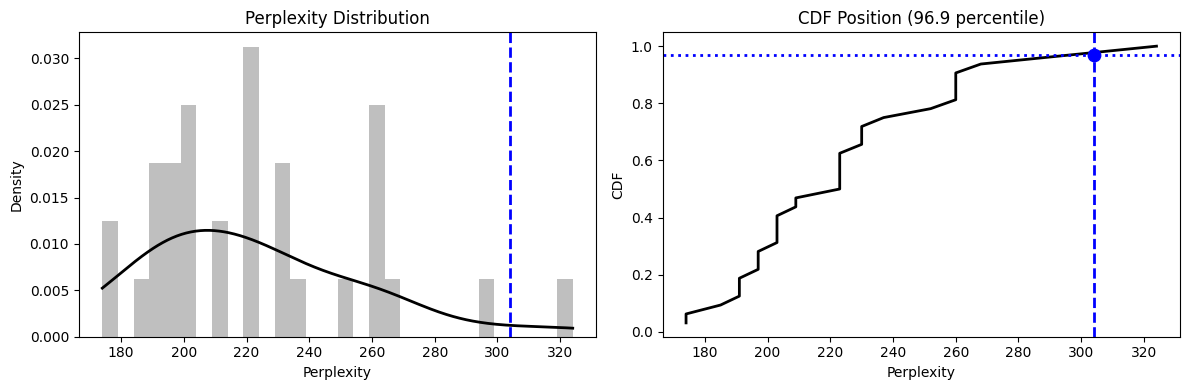

Reference PPL percentile: 96.88


In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

ref_ppl = ppls[0]                              # Reference perplexity
comp_ppls = np.array(ppls[1:])                 # Paraphrase perplexities

kde = gaussian_kde(comp_ppls)                   # KDE fit
x = np.linspace(comp_ppls.min(), comp_ppls.max(), 500)
y = kde(x)

sorted_ppls = np.sort(comp_ppls)                # Sorted values for CDF
cdf = np.arange(1, len(sorted_ppls) + 1) / len(sorted_ppls)
percentile = np.mean(comp_ppls <= ref_ppl) * 100  # Reference percentile

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(comp_ppls, bins=30, density=True, alpha=0.5, color="gray")   # Histogram
axes[0].plot(x, y, color="black", linewidth=2)                             # KDE
axes[0].axvline(ref_ppl, color="blue", linestyle="--", linewidth=2)        # Reference
axes[0].set_title("Perplexity Distribution")
axes[0].set_xlabel("Perplexity")
axes[0].set_ylabel("Density")

axes[1].plot(sorted_ppls, cdf, color="black", linewidth=2)                 # CDF curve
axes[1].axvline(ref_ppl, color="blue", linestyle="--", linewidth=2)        # Reference x
axes[1].axhline(percentile / 100, color="blue", linestyle=":", linewidth=2)# Reference y
axes[1].scatter(ref_ppl, percentile / 100, color="blue", s=80, zorder=3)   # Reference point
axes[1].set_title(f"CDF Position ({percentile:.1f} percentile)")
axes[1].set_xlabel("Perplexity")
axes[1].set_ylabel("CDF")

plt.tight_layout()
plt.show()

print(f"Reference PPL percentile: {percentile:.2f}")
